### Creating baseline for the project using NBSVM (Naive Bayes - Support Vector Machine)

NBSVM was introduced by Sida Wang and Chris Manning in the paper [Baselines and Bigrams: Simple, Good Sentiment and Topic Classiﬁcation](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf)

Author: [Hasil Sharma](https://github.com/Hasil-Sharma/)

## Observations:

- Dataset is multiclass **not** only multilabel

## Constants

In [15]:
TRAIN_DATA_PATH = "../../../data/wikipedia/train.csv"
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
comment_col = 'comment_text'

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.utils.validation import check_X_y
from sklearn.utils.validation import check_array
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.multiclass import unique_labels

from sklearn.model_selection import cross_validate

In [17]:
train = pd.read_csv(TRAIN_DATA_PATH)

In [18]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)

In [19]:
class NbSVMClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, modelType = 'lg', **kwargs):
        self.modelType = modelType
        self.modelArgs = kwargs
        
    def fit(self, X, y):
        
        # Check that X and y have correct shape
        y = y.values
        X, y = check_X_y(X, y, accept_sparse=True, multi_output=True)
        
        self.classes_ = unique_labels(y)
        
        self._clf = []
        self._r = []
        
        def cr(X, y, y_i):
            p = X[y == y_i].sum(axis = 0)
            return (1 + p)/ ((y == y_i).sum() + 1)
        
        for i in self.classes_:
            print('Fitting Model for: ', label_cols[i])
            y_i = y[:, i]
            log_count_ratio = np.log(cr(X, 1,y_i) / cr(X, 0, y_i))
            X_enhanced = X.multiply(log_count_ratio)
            
            if self.modelType == 'lg':
                model = LogisticRegression(**self.modelArgs)
            elif self.modelType == 'svm':
                model = SGDClassifier(**self.modelArgs)
                
            self._clf.append(model.fit(X_enhanced, y_i))
            self._r.append(log_count_ratio)
        
        return self
    
    def predict(self, X):
        check_is_fitted(self, ['_r', '_clf'])
        predict = np.zeros((X.shape[0], len(self.classes_)))
        for i in range(predict.shape[1]):
            predict[:, i] = self._clf[i].predict(X.multiply(self._r[i]))
        return predict
    
    def predict_proba(self, X):
#         if self.modelType == 'svm':
#             print('No Probabilistic Interpretation for SVM')
#             return None
        check_is_fitted(self, ['_r', '_clf'])
        predict_proba = np.zeros((X.shape[0], len(self.classes_)))
        for i in range(predict_proba.shape[1]):
            if self.modelType == 'svm':
                predict_proba[:, i] = self._clf[i].decision_function(X.multiply(self._r[i]))
            else:
                predict_proba[:, i] = self._clf[i].predict_proba(X.multiply(self._r[i]))
        return predict_proba

In [20]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), 
                      min_df = 3, 
                      max_df = 0.9, 
                      strip_accents = 'unicode', use_idf=1,
                      smooth_idf=1, sublinear_tf=1)),
    ('clf', NbSVMClassifier(modelType = 'svm', loss = 'hinge', class_weight = 'balanced', tol = 1e-6))
])

In [21]:
from sklearn.model_selection import learning_curve
train_sizes, train_acc_folds, val_acc_folds = learning_curve(estimator= pipeline, 
                                                     X = train[comment_col],
                                                     train_sizes=np.linspace(0.1, 1, 20),
                                                     y =  train[label_cols], cv = 10,
                                                     scoring = "accuracy",
                                                     shuffle = True, n_jobs = 3)

train_acc = np.mean(train_acc_folds, axis = 1)
train_val = np.mean(val_acc_folds, axis = 1)
print([' %.4f' % score for score in train_val])
print("\nAccuracy: %0.4f (+/- %0.4f)" % (np.mean(train_val), np.std(train_val) * 2))
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 6))
ax.plot(train_sizes, train_acc, lw = 3, color = "steelblue", label = "training")
ax.plot(train_sizes, train_val, lw = 3, color = "green", label = "validation")

ax.grid(alpha=0.25)
ax.set_xlabel("training set size", fontsize=16)
ax.set_ylabel("Accuracy", fontsize=16)
ax.legend(loc="upper right", fontsize=16)

Fitting Model for:  toxic


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  toxic


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  toxic


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  toxic


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  toxic


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  toxic


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  toxic


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  toxic


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  toxic


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  toxic


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  toxic


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  toxic


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  toxic


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate


KeyboardInterrupt: 

[' 0.9168', ' 0.9180', ' 0.9191', ' 0.9197', ' 0.9194', ' 0.9201', ' 0.9202', ' 0.9203', ' 0.9203', ' 0.9204', ' 0.9201', ' 0.9201', ' 0.9203', ' 0.9202', ' 0.9204', ' 0.9203', ' 0.9204', ' 0.9205', ' 0.9205', ' 0.9204']

Accuracy: 0.9199 (+/- 0.0018)


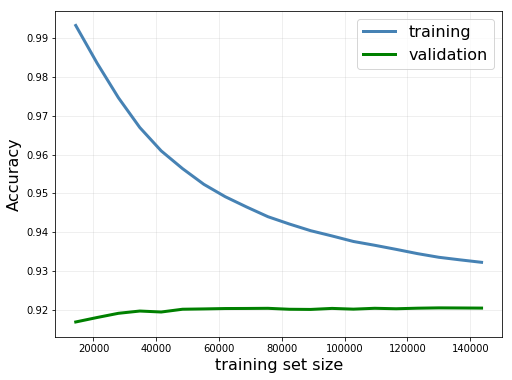

In [28]:
train_acc = np.mean(train_acc_folds, axis = 1)
train_val = np.mean(val_acc_folds, axis = 1)
print([' %.4f' % score for score in train_val])
print("\nAccuracy: %0.4f (+/- %0.4f)" % (np.mean(train_val), np.std(train_val) * 2))
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 6))
ax.plot(train_sizes, train_acc, lw = 3, color = "steelblue", label = "training")
ax.plot(train_sizes, train_val, lw = 3, color = "green", label = "validation")

ax.grid(alpha=0.25)
ax.set_xlabel("training set size", fontsize=16)
ax.set_ylabel("Accuracy", fontsize=16)
ax.legend(loc="upper right", fontsize=16)

In [39]:
%pdb on
cv_results = cross_validate(pipeline, train[comment_col], train[label_cols],
                           n_jobs = 3, return_train_score = False, cv = 10,
                           scoring = 'roc_auc')

Automatic pdb calling has been turned ON
Fitting Model for:  toxic


/home/hasil/.conda/envs/ml-env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  toxic
Fitting Model for:  toxic


/home/hasil/.conda/envs/ml-env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/hasil/.conda/envs/ml-env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  identity_hate
Fitting Model for:  toxic


/home/hasil/.conda/envs/ml-env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  toxic


/home/hasil/.conda/envs/ml-env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  toxic


/home/hasil/.conda/envs/ml-env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  insult
Fitting Model for:  severe_toxic
Fitting Model for:  identity_hate
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  toxic


/home/hasil/.conda/envs/ml-env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  toxic


/home/hasil/.conda/envs/ml-env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  toxic


/home/hasil/.conda/envs/ml-env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate
Fitting Model for:  toxic


/home/hasil/.conda/envs/ml-env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting Model for:  severe_toxic
Fitting Model for:  obscene
Fitting Model for:  threat
Fitting Model for:  insult
Fitting Model for:  identity_hate


In [40]:
cv_results

{'fit_time': array([38.66870809, 58.23814154, 59.02181387, 45.50326872, 51.01447153,
        56.57273531, 51.96861434, 47.10251284, 53.08789873, 43.98268247]),
 'score_time': array([2.80224133, 2.26441073, 3.13931894, 3.61119509, 3.66877818,
        2.86443043, 3.56554651, 2.35198331, 2.5002687 , 1.89054728]),
 'test_score': array([0.97962782, 0.97771139, 0.97903062, 0.97223756, 0.97473903,
        0.97933417, 0.97901685, 0.97617753, 0.97954819, 0.98003277])}

In [41]:
np.mean(cv_results['test_score'])

0.9777455934417734

CV Result with Linear Regression using NB features
``` python
{'fit_time': array([79.08852482, 79.20061374, 42.78198028]),
 'score_time': array([6.6369772 , 6.62154627, 5.88802028]),
 'test_score': array([0.92122728, 0.92169581, 0.92276744])}
 ```
 
 CV Result with Linear SVM using NB features
 ```python
{'fit_time': array([30.04560089, 30.4099865 , 24.19594097]),
 'score_time': array([7.33976412, 7.11350369, 6.19125676]),
 'test_score': array([0.91893365, 0.92066178, 0.9214326 ])}
```